### Binary classification on misinfo labels

/tmp/ipykernel_13756/2260697706.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['label'][row] = 1
/tmp/ipykernel_13756/2260697706.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['label'][row] = 0


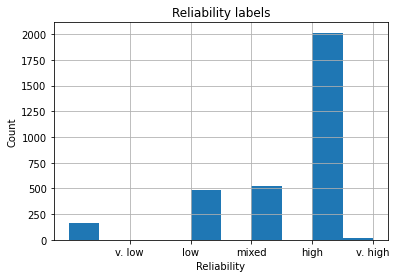

In [1]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
import numpy as np
from catboost import Pool, cv, CatBoostClassifier
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv ('../data/filtered_attrs.csv')
df_filtered = df.copy()
df_filtered.reset_index(drop=True, inplace=True)
fig, ax = plt.subplots()
df_filtered.hist(column='label',ax = ax, align='mid')
ax.set_title('Reliability labels')
ax.set_xlabel('Reliability')
ax.set_ylabel('Count')
ax.set_xticks([2,3,4,5,6])
ax.set_xticklabels(['v. low', 'low', 'mixed', 'high', 'v. high'])

for row, label in enumerate(df_filtered['label']):
    if label > 4:
        df_filtered['label'][row] = 0
    else:
        df_filtered['label'][row] = 1

dropped_cols = ['label', 'url', 'source']
X = df_filtered.drop(columns = dropped_cols)
y = df_filtered['label']
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(X, y, df_filtered.index, test_size=0.2, shuffle=True)

### Misinfo & Bias Classifier Experiments

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

clfs = {
    "Boosted DT": CatBoostClassifier(verbose=False, random_state=0),
    "RF": RandomForestRegressor(n_estimators=50, random_state=0),
    "DT": DecisionTreeClassifier(random_state=0),
    "MLP": MLPClassifier(random_state=0, max_iter=200, hidden_layer_sizes=(200,200)),
    "SVM": svm.SVC(kernel='poly'),
}

reliability_labels = '../data/filtered_labels.csv'
bias_labels = '../data/bias_labels.csv'
label_schemes = {
    'reliability': (reliability_labels, {6:0,5:0,4:1,3:1,2:1,1:1}), # reliability labels
    'abs_bias': (bias_labels, {-2:1,-1:0,0:0,1:0,2:1}), # absolute bias: extreme vs centrist
    'rel_bias': (bias_labels, {-2:0,-1:0,0:-1,1:1,2:1}), # relative bias: left vs right
} 


false_positives = []
false_negatives = []
kf = KFold(n_splits=5, shuffle=True)

results = {}

for (task, (label_path, label_map)) in label_schemes.items():
    results[task] = {}

    features = df_filtered.drop(columns=['label', 'source'])
    task_labels = pd.read_csv(label_path)[['label', 'url']]
    task_df = pd.merge(features, task_labels, on='url', how='inner')
    task_df['label'] = task_df.label.astype(int).replace(label_map)
    task_df = task_df[task_df['label'] != -1]

    _X = task_df.drop(columns=['url','label']).to_numpy()
    _y = task_df['label'].to_numpy()

    for clf_name in clfs.keys():
        accs = []
        f1s = []
        for train_index, test_index in kf.split(_X, _y):
            X_train, X_test = _X[train_index], _X[test_index]
            y_train, y_test = _y[train_index], _y[test_index]
            clf = clfs[clf_name]

            clf = clf.fit(X_train, y_train)
            scores = clf.predict(X_test)
            f1s.append(f1_score(y_test, np.rint(scores)))
            accs.append(accuracy_score(y_test, np.rint(scores)))

        results[task][clf_name] = {}
        results[task][clf_name]['F1'] = {np.mean(f1s)}
        results[task][clf_name]['ACC'] = {np.mean(accs)}
        print(task + ':' +  clf_name + ': ' + str(np.mean(accs)) + f", F1: {np.mean(f1s)}")


FileNotFoundError: [Errno 2] No such file or directory: '../data/filtered_labels.csv'

### Feature Importances

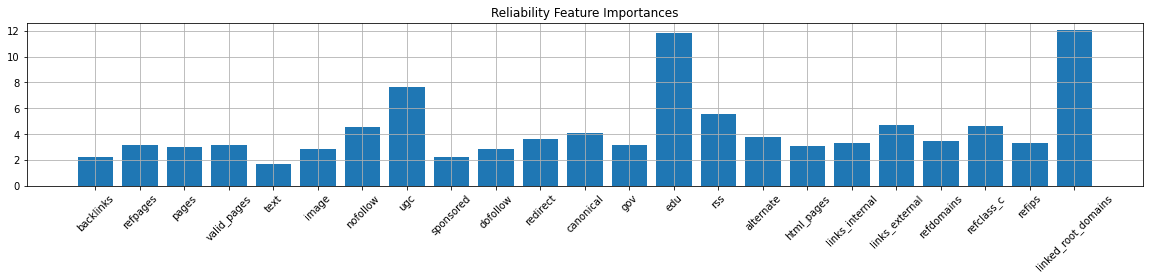

In [ ]:
import matplotlib.pyplot as plt

def plot_importances(importances, features, name):
    plt.figure(figsize=(20, 3))
    plt.bar(range(len(features)), importances, tick_label=features)
    plt.xticks(rotation = 45)
    plt.title(name + ' Feature Importances')
    plt.grid()
    plt.show()

cat_clf = CatBoostClassifier(verbose=False, depth = 5)

cat_clf = cat_clf.fit(X_train, y_train)
plot_importances(cat_clf.get_feature_importance(), X.columns, 'Reliability')

### Classifier Calibration

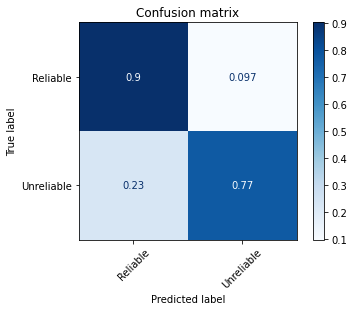

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    cat_clf,
    X_test,
    y_test,
    display_labels=['Reliable', 'Unreliable'],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title('Confusion matrix')
plt.xticks(rotation = 45)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

clfs = {
    "Boosted DT": CatBoostClassifier(verbose=False, random_state=0),
    "RF": RandomForestRegressor(n_estimators=50, random_state=0),
    "DT": DecisionTreeClassifier(random_state=0),
    "MLP": MLPClassifier(random_state=0, max_iter=50, hidden_layer_sizes=(200,200)),
    "SVM": svm.SVC(kernel='linear'),
}
clf = clfs["RF"]
clf = clf.fit(X_train, y_train)

scores = clf.predict(X_test)
for threshold in np.arange(0.1, 0.901, 0.05):
    predictions = scores > threshold
    errors = np.abs(y_test - predictions)

    print("Accuracy for " + str(threshold) + ': ' + str(1-np.mean(errors)))


Accuracy for 0.1: 0.7433903576982892
Accuracy for 0.15000000000000002: 0.7698289269051322
Accuracy for 0.20000000000000004: 0.7822706065318819
Accuracy for 0.25000000000000006: 0.7884914463452566
Accuracy for 0.30000000000000004: 0.8102643856920684
Accuracy for 0.3500000000000001: 0.8133748055987559
Accuracy for 0.40000000000000013: 0.8118195956454122
Accuracy for 0.45000000000000007: 0.8164852255054432
Accuracy for 0.5000000000000001: 0.8133748055987559
Accuracy for 0.5500000000000002: 0.8164852255054432
Accuracy for 0.6000000000000002: 0.8211508553654743
Accuracy for 0.6500000000000001: 0.8118195956454122
Accuracy for 0.7000000000000002: 0.7822706065318819
Accuracy for 0.7500000000000002: 0.7527216174183515
Accuracy for 0.8000000000000002: 0.7153965785381027
Accuracy for 0.8500000000000002: 0.6858475894245724
Accuracy for 0.9000000000000002: 0.6314152410575428


### Bias Classifiers: absolute vs relative

In [ ]:
bias_df = pd.read_csv ('../data/bias_raw.csv')
bias_df.rename(columns={'domain':'url', 'bias':'bias'}, inplace=True)
bias_df.drop_duplicates(subset='url', inplace=True)
bias_df['url'].str.strip()
bias_df.groupby('bias').describe()
df_with_bias = pd.merge(bias_df,df_filtered, on='url', how='inner')

url                                  
             count unique                   top freq
bias                                                
CENTER         847    847      citynews1130.com    1
LEFT           343    343        accountable.us    1
LEFT-CENTER    733    733      autostraddle.com    1
RIGHT          518    518           2ndvote.com    1
RIGHT-CENTER   805    805  birminghammail.co.uk    1

In [ ]:
binary_bias_map = {
    'LEFT': 1,
    'LEFT-CENTER': 0,
    'CENTER': 0,
    'RIGHT-CENTER': 0, 
    'RIGHT': 1,
}
df_binary_bias = df_with_bias.copy()
df_binary_bias["bias"].replace(binary_bias_map, inplace=True)

polarised_bias_map = {
    'LEFT': -1,
    'LEFT-CENTER': -1,
    'CENTER': 0,
    'RIGHT-CENTER': 1, 
    'RIGHT': 1,
}
df_polarised = df_with_bias.copy()
df_polarised["bias"].replace(polarised_bias_map, inplace=True)

bias_map = {
    'LEFT': -2,
    'LEFT-CENTER': -1,
    'CENTER': 0,
    'RIGHT-CENTER': 1, 
    'RIGHT': 2,
}
df_with_bias["bias"].replace(bias_map, inplace=True)
sns.countplot(data=df_with_bias, x="bias", hue="label", palette=['#003da5','#da291c'])
plt.title('Bias distribution by reliability')#')

plt.xlabel('Political Bias')#.set_text('')
plt.ylabel('Frequency Count')
plt.xticks(range(5), ['Extreme left', 'Center left', 'Center', 'Center right', 'Extreme right'], rotation=45)
plt.legend(['Reliable (sum: 2032)', 'Unreliable (sum: 1179)'])
plt.savefig('../results/fig/bias_by_reliability.png', dpi=300, bbox_inches='tight')

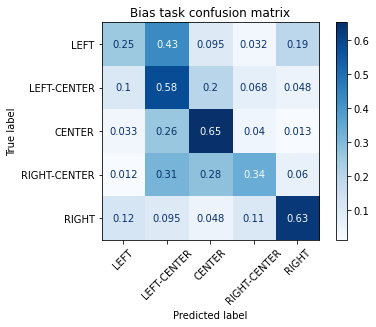

0.33269961977186313


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score

dropped_cols = ['label', 'url', 'source', 'bias']#, 'edu', 'gov','ugc' ]
X = df_with_bias.drop(columns = dropped_cols)
y = df_with_bias['bias']
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(X, y, df_with_bias.index, test_size=0.2, shuffle=True)

clfs = {
    "Boosted DT": CatBoostClassifier(verbose=False, random_state=0),
    "RF": RandomForestClassifier(n_estimators=50, random_state=0),
    "DT": DecisionTreeClassifier(random_state=0),
    "MLP": MLPClassifier(random_state=0, max_iter=50, hidden_layer_sizes=(200,200)),
    "SVM": svm.SVC(kernel='linear'),
}
bias_clf = clfs["Boosted DT"]
bias_clf = bias_clf.fit(X_train, y_train)

scores = bias_clf.predict(X_test)
predictions = scores > 0.5
# print(scores)


disp = ConfusionMatrixDisplay.from_estimator(
    bias_clf,
    X_test,
    y_test,
    display_labels=bias_map.keys(),
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title('Bias task confusion matrix')
plt.xticks(rotation = 45)
plt.show() 

print(accuracy_score(y_test, predictions))
# print(f"AUC: {roc_auc_score(y_test, predictions)}")



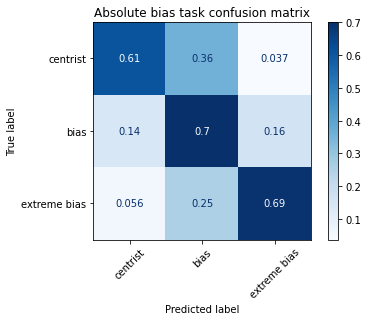

0.6692015209125475


In [ ]:
X = df_with_bias.drop(columns = dropped_cols)
y = df_with_bias['bias'].abs()
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(X, y, df_with_bias.index, test_size=0.2, shuffle=True)

clfs = {
    "Boosted DT": CatBoostClassifier(verbose=False, random_state=0),
    "RF": RandomForestClassifier(n_estimators=50, random_state=0),
    "DT": DecisionTreeClassifier(random_state=0),
    "MLP": MLPClassifier(random_state=0, max_iter=50, hidden_layer_sizes=(200,200)),
    "SVM": svm.SVC(kernel='linear'),
}
abs_bias_clf = clfs["Boosted DT"]
abs_bias_clf = abs_bias_clf.fit(X_train, y_train)

scores = abs_bias_clf.predict(X_test)
predictions = np.rint(scores)

# print(scores)
disp = ConfusionMatrixDisplay.from_estimator(
    abs_bias_clf,
    X_test,
    y_test,
    display_labels=['centrist', 'bias', 'extreme bias'],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title('Absolute bias task confusion matrix')
plt.xticks(rotation = 45)
plt.show() 


print(accuracy_score(y_test, predictions))
# print(f"AUC: {roc_auc_score(y_test, predictions)}")


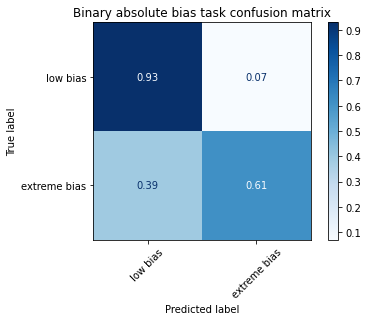

0.8365019011406845
AUC: 0.6884057971014492


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score


X = df_binary_bias.drop(columns = dropped_cols)
y = df_binary_bias['bias'].abs()
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(X, y, df_binary_bias.index, test_size=0.2, shuffle=True)

clfs = {
    "Boosted DT": CatBoostClassifier(verbose=False, random_state=0),
    "RF": RandomForestClassifier(n_estimators=50, random_state=0),
    "DT": DecisionTreeClassifier(random_state=0),
    "MLP": MLPClassifier(random_state=0, max_iter=50, hidden_layer_sizes=(200,200)),
    "SVM": svm.SVC(kernel='linear'),
}
abs_bin_bias_clf = clfs["Boosted DT"]
abs_bin_bias_clf = abs_bias_clf.fit(X_train, y_train)

scores = abs_bin_bias_clf.predict(X_test)
predictions = np.rint(scores)

# print(scores)
disp = ConfusionMatrixDisplay.from_estimator(
    abs_bin_bias_clf,
    X_test,
    y_test,
    display_labels=['low bias', 'extreme bias'],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title('Binary absolute bias task confusion matrix')
plt.xticks(rotation = 45)
plt.show()


print(accuracy_score(y_test, predictions))
print(f"AUC: {f1_score(y_test, predictions)}")

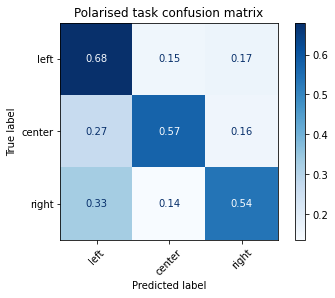

0.6026615969581749


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score

dropped_cols = ['label', 'url', 'source', 'bias']#, 'edu', 'gov','ugc' ]
X = df_polarised.drop(columns = dropped_cols)
y = df_polarised['bias']
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(X, y, df_polarised.index, test_size=0.2, shuffle=True)

clfs = {
    "Boosted DT": CatBoostClassifier(verbose=False, random_state=0),
    "RF": RandomForestClassifier(n_estimators=50, random_state=0),
    "DT": DecisionTreeClassifier(random_state=0),
    "MLP": MLPClassifier(random_state=0, max_iter=50, hidden_layer_sizes=(200,200)),
    "SVM": svm.SVC(kernel='linear'),
}
polar_clf = clfs["Boosted DT"]
polar_clf = polar_clf.fit(X_train, y_train)

scores = polar_clf.predict(X_test)
predictions = np.rint(scores)
# print(scores)


disp = ConfusionMatrixDisplay.from_estimator(
    polar_clf,
    X_test,
    y_test,
    display_labels=['left', 'center', 'right'],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title('Polarised task confusion matrix')
plt.xticks(rotation = 45)
plt.show() 

print(accuracy_score(y_test, predictions))
# print(f"AUC: {roc_auc_score(y_test, predictions)}")



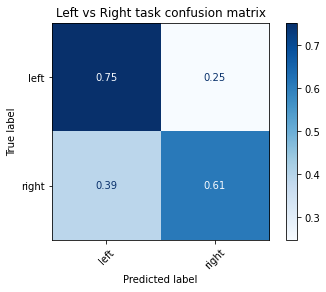

0.695054945054945
F1: 0.615916955017301


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

dropped_cols = ['label', 'url', 'source', 'bias']#, 'edu', 'gov','ugc' ]
df_polarised_bin = df_polarised[df_polarised['bias'] != 0]
X = df_polarised_bin.drop(columns = dropped_cols)
y = df_polarised_bin['bias']
X_train, X_test, y_train, y_test, ind_train, ind_test = train_test_split(X, y, df_polarised_bin.index, test_size=0.2, shuffle=True)

clfs = {
    "Boosted DT": CatBoostClassifier(verbose=False, random_state=0),
    "RF": RandomForestClassifier(n_estimators=50, random_state=0),
    "DT": DecisionTreeClassifier(random_state=0),
    "MLP": MLPClassifier(random_state=0, max_iter=50, hidden_layer_sizes=(200,200)),
    "SVM": svm.SVC(kernel='linear'),
}
polar_clf = clfs["Boosted DT"]
polar_clf = polar_clf.fit(X_train, y_train)

scores = polar_clf.predict(X_test)
predictions = np.rint(scores)
# print(scores)


disp = ConfusionMatrixDisplay.from_estimator(
    polar_clf,
    X_test,
    y_test,
    display_labels=['left', 'right'],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title('Left vs Right task confusion matrix')
plt.xticks(rotation = 45)
plt.show() 

print(accuracy_score(y_test, predictions))
print(f"F1: {f1_score(y_test, predictions)}")



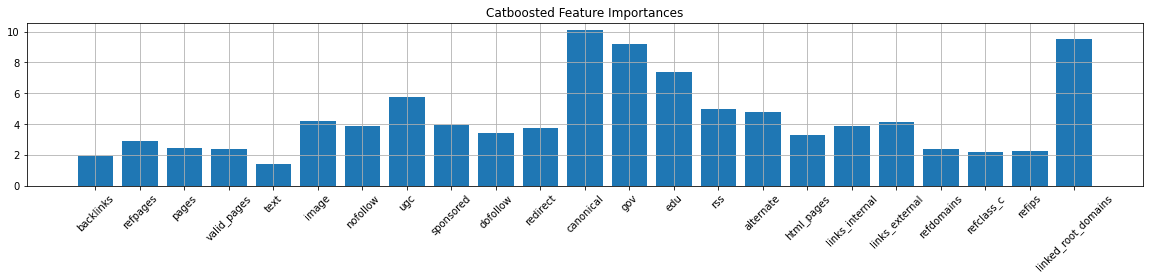

In [ ]:
features = X_test.columns.to_numpy()
plot_importances(bias_clf.get_feature_importance(), features, 'Catboosted')